# Exploratory Data Analysis Notebook
This notebook is dedicated to the exploratory data analysis of the large and focused final data sets. General facts about the data will be recorded and available in the following cells. Should it be warranted, they may also appear in the README file. We'll be using Pandas and Numpy for data processing and analysis and `matplotlib` and `seaborn` for data visualization. The first step is to load in the libraries and the data we're interested in. This data has already been cleaned up, but it still contains null values in some attributes that will have to handled during certain operations.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plot
import seaborn as sbn
from typing import Dict, Tuple

# Import utility functions
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from utils import *
from classes import Plotter

df = pd.read_parquet(path='../data/processed/composite/dataset_focused.parquet')

,cveID,vendorProject,product,vulnerabilityName,dateAdded,shortDescription,requiredAction,dueDate,knownRansomwareCampaignUse,notes,cwes
1,CVE-2024-53704,SonicWall,SonicOS,SonicWall SonicOS SSLVPN Improper Authenticati...,2025-02-18,SonicWall SonicOS contains an improper authent...,Apply mitigations per vendor instructions or d...,2025-03-11,Unknown,https://psirt.global.sonicwall.com/vuln-detail...,CWE-287


The first thing to look at are general facts about the data we're interested in.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10891 entries, 0 to 10890
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   cve_id                10891 non-null  string             
 1   date_public           10678 non-null  datetime64[ns, UTC]
 2   origin                10891 non-null  category           
 3   cvss                  10290 non-null  Float64            
 4   cvss_severity         10891 non-null  category           
 5   cvss_src              10290 non-null  category           
 6   exploit_count         10891 non-null  Float64            
 7   days_to_poc_exploit   10678 non-null  Float64            
 8   exploitation_date_0   10891 non-null  datetime64[ns, UTC]
 9   epss_0                2886 non-null   Float64            
 10  percentile_0          2886 non-null   Float64            
 11  exploitation_date_30  10891 non-null  datetime64[ns, UTC]
 12  epss

There are no CVEs who have EPSS scores but do not have their corresponding percentiles, which is to be expected.

In [4]:
df[df['epss_0'].notnull() & df['percentile_0'].isnull()]

,cve_id,date_public,origin,cvss,cvss_severity,cvss_src,exploit_count,days_to_poc_exploit,exploitation_date_0,epss_0,percentile_0,exploitation_date_30,epss_30,percentile_30,exploitation_date_60,epss_60,percentile_60,change_0_to_30,change_30_to_60,change_0_60


The following diagram shows the amount of missing data in the dataset, represented by the color yellow. 

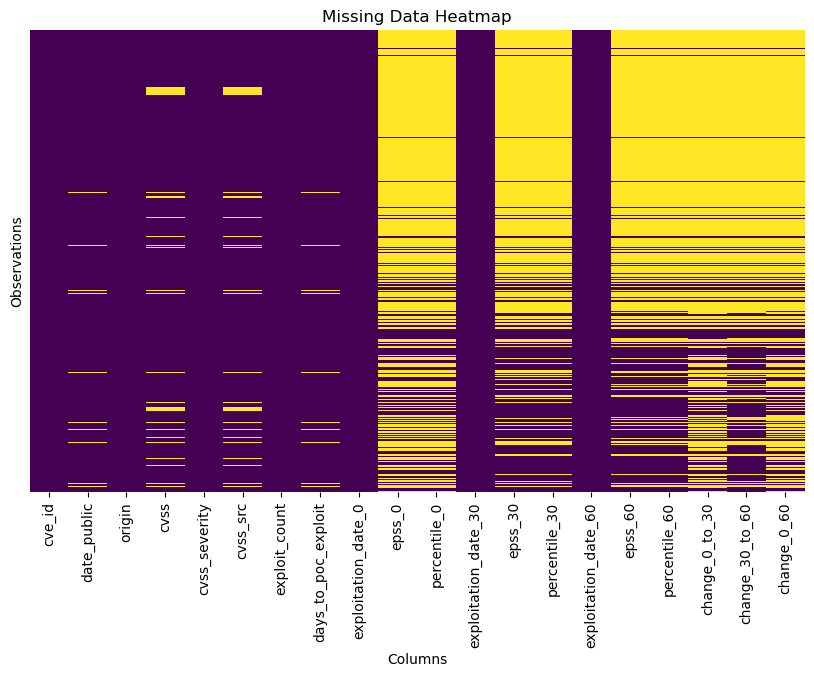

In [2]:
missing_values = df.isnull().sum()

# Plot missing data heatmap
plot.figure(figsize=(10, 6))
sbn.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plot.title('Missing Data Heatmap')
plot.xlabel("Columns")
plot.ylabel("Observations")
plot.show()

In [7]:
print(f'There are \033[32;1m{df.shape[0]}\033[0m CVE records in the data frame, each with \033[32;1m{df.shape[1]}\033[0m attributes.')
print('Some general statistics about the numerical columns:')

# Change output display for clarity
pd.options.display.precision = 3
df.describe().T

There are 10891 CVE records in the data frame, each with 20 attributes.
Some general statistics about the numerical columns:


,count,mean,std,min,25%,50%,75%,max
cvss,10290.0,7.36,1.794,0.0,6.1,7.5,8.8,10.0
exploit_count,10891.0,1.86,5.999,1.0,1.0,1.0,1.0,394.0
days_to_poc_exploit,10678.0,230.404,790.141,-4457.0,0.0,1.0,66.0,9978.0
epss_0,2886.0,0.072,0.194,0.0,0.001,0.007,0.023,0.976
percentile_0,2886.0,0.488,0.317,0.008,0.194,0.42,0.788,1.0
epss_30,3965.0,0.099,0.224,0.0,0.001,0.009,0.05,0.975
percentile_30,3965.0,0.554,0.334,0.008,0.229,0.563,0.895,1.0
epss_60,4008.0,0.104,0.233,0.0,0.001,0.009,0.055,0.975
percentile_60,4008.0,0.557,0.334,0.008,0.243,0.565,0.898,1.0
change_0_to_30,2824.0,2647.929,17799.523,-97.069,0.0,0.0,107.846,226241.86


There are $601$ CVEs with `UNKNOWN` CVSS score severities because leaving them `NaN` would have conflicted with the `NONE` category.

In [8]:
df[(df['cvss'].isnull()) & (df['cvss_severity'].notnull())]['cvss_severity'].value_counts()

cvss_severity
UNKNOWN     601
CRITICAL      0
HIGH          0
LOW           0
MEDIUM        0
NONE          0
Name: count, dtype: int64

The following table shows summary statistics for the dataset's date variables.

In [9]:
date_cols = df.select_dtypes('datetime64[ns, UTC]').columns
df[date_cols].describe().T

,count,mean,min,25%,50%,75%,max
date_public,10678,2016-01-07 08:06:07.169118464+00:00,1990-08-14 04:00:00+00:00,2008-12-01 00:00:00+00:00,2018-04-19 12:00:00+00:00,2022-05-24 23:53:15+00:00,2025-01-28 22:15:15.860000+00:00
exploitation_date_0,10891,2016-10-06 01:45:41.016527616+00:00,1990-05-19 00:00:00+00:00,2009-04-20 00:00:00+00:00,2019-10-15 06:26:08+00:00,2023-01-31 22:51:30+00:00,2025-01-13 10:07:25+00:00
exploitation_date_30,10891,2016-11-05 01:45:41.016527360+00:00,1990-06-18 00:00:00+00:00,2009-05-20 00:00:00+00:00,2019-11-14 06:26:08+00:00,2023-03-02 22:51:30+00:00,2025-02-12 10:07:25+00:00
exploitation_date_60,10891,2016-12-05 01:45:41.016527360+00:00,1990-07-18 00:00:00+00:00,2009-06-19 00:00:00+00:00,2019-12-14 06:26:08+00:00,2023-04-01 22:51:30+00:00,2025-03-14 10:07:25+00:00


## Answering Questions


In [3]:
cvss_greater_than_or_equal_to_7 = df[df['cvss'] >= 7.0]
cvss_greater_than_or_equal_to_7_count = len(cvss_greater_than_or_equal_to_7)
nonnull_epss_0 = cvss_greater_than_or_equal_to_7[cvss_greater_than_or_equal_to_7['epss_0'].notnull()]
nonnull_epss_30 = cvss_greater_than_or_equal_to_7[cvss_greater_than_or_equal_to_7['epss_30'].notnull()]
nonnull_epss_60 = cvss_greater_than_or_equal_to_7[cvss_greater_than_or_equal_to_7['epss_60'].notnull()]
valid_epss_0_threshold = nonnull_epss_0[nonnull_epss_0['epss_0'] >= 0.5]
valid_epss_30_threshold = nonnull_epss_30[nonnull_epss_30['epss_30'] >= 0.5]
valid_epss_60_threshold = nonnull_epss_60[nonnull_epss_60['epss_60'] >= 0.5]

print(f'There are \033[32;1m{cvss_greater_than_or_equal_to_7_count}\033[0m CVEs with a CVSS score greater than or equal to 7.0.')
print(f"This is \033[32;1m{(cvss_greater_than_or_equal_to_7_count / df['cvss'].count()) * 100:.2f}%\033[0m of the total number of CVSS scores.")
print(f'These CVEs are henceforth refered to at "valid".')
print(f'Of valid CVEs, \033[32;1m{len(nonnull_epss_0)}\033[0m have non-null EPSS scores at day 0.')
print(f'\033[32;1m{len(valid_epss_0_threshold)}\033[0m of the CVEs have EPSS scores that fall above a threshold of 0.5.')
print(f'This is \033[32;1m{(len(valid_epss_0_threshold) / len(nonnull_epss_0)) * 100:.2f}%\033[0m of EPSS scores among valid CVEs.')
print(f"It's also \033[32;1m{(len(valid_epss_0_threshold) / df['epss_0'].count()) * 100:.2f}%\033[0m of the total number of EPSS scores.")
print(f"Day 30 scores number in at \033[32;1m{len(nonnull_epss_30)}\033[0m, \033[32;1m{(len(valid_epss_30_threshold) / len(nonnull_epss_30)) * 100:.2f}%\033[0m of valid CVEs and \033[32;1m{(len(valid_epss_30_threshold) / df['epss_30'].count()) * 100:.2f}%\033[0m of total CVEs.")
print(f"Day 60 scores number in at \033[32;1m{len(nonnull_epss_60)}\033[0m, \033[32;1m{(len(valid_epss_60_threshold) / len(nonnull_epss_60)) * 100:.2f}%\033[0m of valid CVEs  and \033[32;1m{(len(valid_epss_60_threshold) / df['epss_60'].count()) * 100:.2f}%\033[0m of total CVEs.")

There are 6706 CVEs with a CVSS score greater than or equal to 7.0.
This is 65.17% of the total number of CVSS scores.
These CVEs are henceforth refered to at "valid".
Of valid CVEs, 2169 have non-null EPSS scores at day 0.
134 of the CVEs have EPSS scores that fall above a threshold of 0.5.
This is 6.18% of EPSS scores among valid CVEs.
It's also 4.64% of the total number of EPSS scores.
Day 30 scores number in at 2824, 9.53% of valid CVEs and 6.78% of total CVEs.
Day 60 scores number in at 2822, 10.35% of valid CVEs  and 7.29% of total CVEs.


### Average Number of Days Under Various Conditions (Unfiltered Data)

In [4]:
# Subconditional filtering
total_cves = df['days_to_poc_exploit'].notna()
later_than_0_cves = df['days_to_poc_exploit'] >= 0
sooner_than_90_cves = df['days_to_poc_exploit'] <= 90
within_90_cves = later_than_0_cves & (df['days_to_poc_exploit'] <= 90)
negative_day_cves = df['days_to_poc_exploit'] < 0

# Criticality filter
high_critical_cves = df['cvss'] >= 7.0

# Combined filters
high_critical_and_later_than_0_cves = later_than_0_cves & high_critical_cves
high_critical_and_sooner_than_90_cves = sooner_than_90_cves & high_critical_cves
high_critical_and_within_90_cves = within_90_cves & high_critical_cves
high_critical_and_negative_day_cves = negative_day_cves & high_critical_cves

print_avg_time(df, total_cves, 'all CVEs')
print_avg_time(df, later_than_0_cves, 'CVEs whose exploit codes were published \033[33;1mafter the CVE was made public\033[0m')
print_avg_time(df, sooner_than_90_cves, "CVEs whose exploit codes were published \033[33;1msooner than 90 days\033[0m")
print_avg_time(df, within_90_cves, "CVEs whose exploit codes were published \033[33;1mwithin the first 90 days\033[0m")
print_avg_time(df, negative_day_cves, "CVEs whose first exploit code is published \033[33;1mbefore the CVE is known\033[0m")

Average number of days from CVE publication to publication of first exploit code for all CVEs: 230 days 10 hours 42 minutes 2 seconds.
Average number of days from CVE publication to publication of first exploit code for CVEs whose exploit codes were published after the CVE was made public: 321 days 20 hours 11 minutes 3 seconds.
Average number of days from CVE publication to publication of first exploit code for CVEs whose exploit codes were published sooner than 90 days: -17 days 9 hours 10 minutes 43 seconds.
Average number of days from CVE publication to publication of first exploit code for CVEs whose exploit codes were published within the first 90 days: 10 days 1 hours 24 minutes 1 seconds.
Average number of days from CVE publication to publication of first exploit code for CVEs whose first exploit code is published before the CVE is known: -81 days 15 hours 22 minutes 49 seconds.


Transformation type unknown: None
No transformation applied to days_to_poc_exploit.
Plot saved: ../plots\frequency_of_various_days_to_exploit_publication_for_negative_days.png


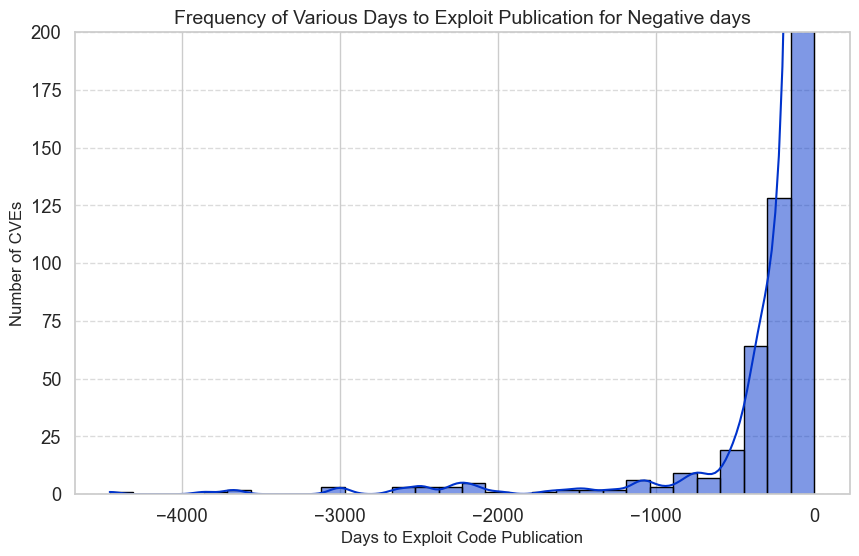

In [20]:
# Plot histograms
plotter.plot_histogram(
    neg_df,
    column='days_to_poc_exploit',
    title='Frequency of Various Days to Exploit Publication for Negative days',
    xlabel='Days to Exploit Code Publication',
    ylabel='Number of CVEs',
    # bins=np.arange(0, df['cvss'].max() + 1, 1),
    alpha=0.5,
    # ylim=(0, 200)
    ylim=(0, 200)
)

#### Counts and Percentages of CVEs Under Various Conditions

In [3]:
def print_cve_count(
        df: pd.DataFrame,
        condition: pd.Series,
        description: str
    ) -> None:
    '''Compute and print the count and percentage of CVEs matching a condition.'''
    count = condition.sum()
    percentage = (count / len(df)) * 100
    print(f'There are \033[32;1m{count}\033[0m (\033[32;1m{percentage:.2f}%\033[0m of total) {description}.')

print_cve_count(df, sooner_than_90_cves, "CVEs whose exploit codes were published \033[32;1msooner than 90 days\033[0m")
print_cve_count(df, high_critical_and_sooner_than_90_cves, "high criticality CVEs published \033[32;1msooner than 90 days\033[0m")
print_cve_count(df, within_90_cves, "CVEs whose exploit codes were published \033[32;1mwithin 90 days\033[0m")
print_cve_count(df, high_critical_and_within_90_cves, "high criticality CVEs published \033[32;1mwithin 90 days\033[0m")
print_cve_count(df, negative_day_cves, "CVEs whose exploit codes were published \033[32;1mbefore CVE disclosure\033[0m")
print_cve_count(df, high_critical_and_negative_day_cves, "high criticality CVEs published \033[32;1mbefore CVE disclosure\033[0m")
print_cve_count(df, later_than_0_cves, "CVEs whose exploit codes were published \033[32;1mbefore CVE disclosure\033[0m")
print_cve_count(df, high_critical_and_later_than_0_cves, "high criticality CVEs published \033[32;1mbefore CVE disclosure\033[0m")

There are 8228 (75.55% of total) CVEs whose exploit codes were published sooner than 90 days.
There are 4926 (45.23% of total) high criticality CVEs published sooner than 90 days.
There are 5827 (53.50% of total) CVEs whose exploit codes were published within 90 days.
There are 3564 (32.72% of total) high criticality CVEs published within 90 days.
There are 2401 (22.05% of total) CVEs whose exploit codes were published before CVE disclosure.
There are 1362 (12.51% of total) high criticality CVEs published before CVE disclosure.
There are 8277 (76.00% of total) CVEs whose exploit codes were published before CVE disclosure.
There are 5344 (49.07% of total) high criticality CVEs published before CVE disclosure.


#### Boxplot Outlier Visualization
From the boxplot, it's clear that the variable tracking the number of days from when the CVE was published to the date of the first exploit code publication is profoundly skewed by extreme outliers. To handle these, we can filter the data for just those CVEs that fall within the interquartile range (IQR), a method that is robust against non-normal data distributions.

In [2]:
# Load Plotter
plotter = Plotter(figsize=(10, 6), save_fig=True)

In [ ]:
# Plot boxplots
plotter.plot_box(
    df,
    column='days_to_poc_exploit',
    title='Days from CVE publication to publication of first exploit code',
    xlabel='Days',
    ylabel='Number of CVEs',
    xlim=(-2000, 2000)
)

### Outlier-Filtered IQR Data
<span style='color:#ffcc00;text-shadow:0 0 3px #ffcc00;'>Based on the interquartile range of <span style='font-family: "JetBrains Mono", monospace;color:#D6BB7D;background-color:#585D67;padding-inline:0.2rem;text-shadow:none;'>days_to_poc_exploit</span>, the following code cell calculates the number of extreme outliers removed to stabilize the mean and provide a more accurate estimate.</span>


In [7]:
# Compute Q1, Q3, and IQR
Q1 = df['days_to_poc_exploit'].quantile(0.25)
Q3 = df['days_to_poc_exploit'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for non-extreme values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to exclude extreme outliers
iqr_df = df[(df['days_to_poc_exploit'] >= lower_bound) & (df['days_to_poc_exploit'] <= upper_bound)].copy()

print(f'\033[32;1m{len(df) - len(iqr_df)}\033[0m extreme outlier CVEs were removed from the dataset. \033[32;1m{len(iqr_df)}\033[0m remain to be analyzed.')

2610 extreme outlier CVEs were removed from the dataset. 8281 remain to be analyzed.


#### Average Number of Days Under Various Conditions

In [3]:
# Subconditional filtering
total_cves = iqr_df['days_to_poc_exploit'].notna()
later_than_0_cves = iqr_df['days_to_poc_exploit'] >= 0
sooner_than_90_cves = iqr_df['days_to_poc_exploit'] <= 90
within_90_cves = later_than_0_cves & (iqr_df['days_to_poc_exploit'] <= 90)
negative_day_cves = iqr_df['days_to_poc_exploit'] < 0

# Criticality filter
high_critical_cves = iqr_df['cvss'] >= 7.0

# Combined filters
high_critical_and_later_than_0_cves = later_than_0_cves & high_critical_cves
high_critical_and_sooner_than_90_cves = sooner_than_90_cves & high_critical_cves
high_critical_and_within_90_cves = within_90_cves & high_critical_cves
high_critical_and_negative_day_cves = negative_day_cves & high_critical_cves

print_avg_time(iqr_df, total_cves, '\033[33;1mall CVEs\033[0m')
print_avg_time(iqr_df, later_than_0_cves, 'CVEs whose exploit codes were published \033[33;1mafter the CVE was made public\033[0m')
print_avg_time(iqr_df, sooner_than_90_cves, "CVEs whose exploit codes were published \033[33;1msooner than 90 days\033[0m")
print_avg_time(iqr_df, within_90_cves, "CVEs whose exploit codes were published \033[33;1mwithin the first 90 days\033[0m")
print_avg_time(iqr_df, negative_day_cves, "CVEs whose first exploit code is published \033[33;1mbefore the CVE is known\033[0m")

NameError: name 'iqr_df' is not defined

## Verifying Distributive Normalcy


### Histogram, Q-Q Plots, and Scatterplots
From the looks of the histogram and Q-Q plots, none of the project's variables appear to be normally distributed; rather, they seem heavily skewed to the right, exponential, and perhaps bimodal. We can't rely on appearances alone though, so in the next section, we'll use several statistical tests to verify the data's shape mathematically.

Based on the results of these tests, we can perform correlation analysis with the Spearman's Rank Coefficient and Kendall's Tau and begin to flesh out an analysis that will help validate the effectiveness of the project's model versus the CVSS and EPSS parameters. Scatterplots graphing the relationship between variables will help in this endeavour to visualize any relationships that may emerge.

#### Unfiltered Data

In [ ]:
# Plot histograms
plotter.plot_histogram(
    df,
    column='cvss',
    title='Frequency of CVEs with varying CVSS scores',
    xlabel='CVSS Score',
    ylabel='Number of CVEs',
    bins=np.arange(0, df['cvss'].max() + 1, 1),
    alpha=0.5,
    ylim=(0, 2000)
)

# Define xlabels for severity
xlabels = ['NONE', 'LOW', 'MEDIUM', 'HIGH', 'CRITICAL']

# Alphabetically reorder severity categories
df['cvss_severity'] = pd.Categorical(df['cvss_severity'], categories=xlabels, ordered=True)

plotter.plot_histogram(
    df=df[df['cvss_severity'] != 'UNKNOWN'],
    column='cvss_severity',
    title='Frequency of CVSS Severity Levels',
    xlabel='CVSS Severity',
    ylabel='Number of CVEs',
    bins=10,
    alpha=0.5,
    ylim=(0, 5000),
    discrete=True,
    kde=False,
    xlabels=xlabels
)
plotter.plot_histogram(
    df,
    column='exploit_count',
    title='Distribution of Exploit Counts',
    xlabel='Exploit Count',
    ylabel='Number of CVEs',
    bins=np.arange(0, df['exploit_count'].max() + 1, 1) - 0.5,
    alpha=0.5,
    xlim=(0, 10),
    ylim=(0, 5000),
    transform='log',
    discrete=True,
    kde=False
)
plotter.plot_histogram(
    df,
    column='days_to_poc_exploit',
    title='Time to First Exploit Code Publishing',
    xlabel='Days From Public Disclosure',
    ylabel='Number of CVEs',
    bins=100,
    alpha=0.5,
    xlim=(-500, 3000)
)
plotter.plot_histogram(
    df,
    column='epss_0',
    title='EPSS Scores on Exploit Code Publish Date',
    xlabel='EPSS Score',
    ylabel='Number of CVEs',
    bins=100,
    alpha=0.5,
    xlim=(0.001, 1.000),
    # ylim=(0, 200)
)
plotter.plot_histogram(
    df,
    column='epss_30',
    title='EPSS Scores 30 Days After Exploit Code Publish Date',
    xlabel='EPSS Score',
    ylabel='Number of CVEs',
    bins=100,
    alpha=0.5,
    xlim=(0.001, 1.000),
    # ylim=(0, 200)
)
plotter.plot_histogram(
    df,
    column='epss_60',
    title='EPSS Scores 60 Days After Exploit Code Publish Date',
    xlabel='EPSS Score',
    ylabel='Number of CVEs',
    bins=100,
    alpha=0.5,
    xlim=(0.001, 1.000),
    # ylim=(0, 200)
)

<span style='color:#ffcc00;text-shadow:0 0 3px #ffcc00;'>NOTE: Generating Q-Q plots of categorical data (<span style='font-family: "JetBrains Mono", monospace;color:#D6BB7D;background-color:#585D67;padding-inline:0.2rem;text-shadow:none;'>cvss_severity</span>) is not immediately possible.</span>

In [ ]:
# Configure Q-Q plots
plotter.plot_qq(
    df,
    column='cvss',
    dist='norm',
    title='QQ Plot of CVSS Scores',
    xlabel='Theoretical Quantiles',
    ylabel='CVSS Scores',
    color='blue',
)
plotter.plot_qq(
    df,
    column='exploit_count',
    dist='norm',
    title='QQ Plot of Exploit Count',
    xlabel='Theoretical Quantiles',
    ylabel='Number of Exploits',
    color='blue'
)
plotter.plot_qq(
    df,
    column='days_to_poc_exploit',
    dist='norm',
    title='QQ Plot of the Interval Between CVE Disclosure and Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='Days to Exploit Code Publishing',
    color='blue',
)
plotter.plot_qq(
    df,
    column='epss_0',
    dist='norm',
    title='QQ Plot of EPSS Scores on Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    df,
    column='epss_30',
    dist='norm',
    title='QQ Plot of EPSS Scores 30 Days After on Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    df,
    column='epss_60',
    dist='norm',
    title='QQ Plot of EPSS Scores 60 Days After Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    df,
    column='change_0_to_30',
    dist='norm',
    title='QQ Plot of Change Rate of EPSS Scores Across 30 Days From Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    df,
    column='change_30_to_60',
    dist='norm',
    title='QQ Plot of Change Rate of EPSS Scores 30-60 Days After Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    df,
    column='change_0_60',
    dist='norm',
    title='QQ Plot of Change Rate of EPSS Scores Across 60 Days From Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)

#### Outlier-Filtered IQR Data

In [ ]:
# Plot histograms
plotter.plot_histogram(
    iqr_df,
    column='cvss',
    title='Frequency of CVEs with varying CVSS scores of IQR Data',
    xlabel='CVSS Score',
    ylabel='Number of CVEs',
    bins=np.arange(0, df['cvss'].max() + 1, 1),
    alpha=0.5,
    # ylim=(0, 2000)
)

# Alphabetically reorder severity categories
iqr_df['cvss_severity'] = pd.Categorical(iqr_df['cvss_severity'], categories=xlabels, ordered=True)

plotter.plot_histogram(
    df=iqr_df[iqr_df['cvss_severity'] != 'UNKNOWN'],
    column='cvss_severity',
    title='Frequency of CVSS Severity Levels of IQR Data',
    xlabel='CVSS Severity',
    ylabel='Number of CVEs',
    bins=10,
    alpha=0.5,
    ylim=(0, 5000),
    discrete=True,
    kde=False,
    xlabels=xlabels
)
plotter.plot_histogram(
    iqr_df,
    column='exploit_count',
    title='Distribution of Exploit Counts of IQR Data',
    xlabel='Exploit Count',
    ylabel='Number of CVEs',
    bins=np.arange(0, df['exploit_count'].max() + 1, 1) - 0.5,
    alpha=0.5,
    xlim=(0, 10),
    ylim=(0, 7500),
    transform='log',
    discrete=True,
    kde=False
)
plotter.plot_histogram(
    iqr_df,
    column='days_to_poc_exploit',
    title='Time to First Exploit Code Publishing of IQR Data',
    xlabel='Days From Public Disclosure',
    ylabel='Number of CVEs',
    bins=100,
    alpha=0.5
)

In [ ]:
# Configure Q-Q plots
plotter.plot_qq(
    iqr_df,
    column='cvss',
    dist='norm',
    title='IQR QQ Plot of CVSS Scores',
    xlabel='Theoretical Quantiles',
    ylabel='CVSS Scores',
    color='blue',
)
plotter.plot_qq(
    iqr_df,
    column='exploit_count',
    dist='norm',
    title='IQR QQ Plot of Exploit Count',
    xlabel='Theoretical Quantiles',
    ylabel='Number of Exploits',
    color='blue'
)
plotter.plot_qq(
    iqr_df,
    column='days_to_poc_exploit',
    dist='norm',
    title='IQR QQ Plot of the Interval Between CVE Disclosure and Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='Days to Exploit Code Publishing',
    color='blue',
)
plotter.plot_qq(
    iqr_df,
    column='epss_0',
    dist='norm',
    title='IQR QQ Plot of EPSS Scores on Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    iqr_df,
    column='epss_30',
    dist='norm',
    title='IQR QQ Plot of EPSS Scores 30 Days After on Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    iqr_df,
    column='epss_60',
    dist='norm',
    title='IQR QQ Plot of EPSS Scores 60 Days After Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    iqr_df,
    column='change_0_to_30',
    dist='norm',
    title='IQR QQ Plot of Change Rate of EPSS Scores Across 30 Days From Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    iqr_df,
    column='change_30_to_60',
    dist='norm',
    title='IQR QQ Plot of Change Rate of EPSS Scores 30-60 Days After Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)
plotter.plot_qq(
    iqr_df,
    column='change_0_60',
    dist='norm',
    title='IQR QQ Plot of Change Rate of EPSS Scores Across 60 Days From Exploit Code Publish Date',
    xlabel='Theoretical Quantiles',
    ylabel='EPSS Scores',
    color='blue',
)

### Statistical Normality Testing
We'll make use of two common statistical tests for normality: the **Anderson-Darling** and the **Kolmogorov-Smirnov**. Another common test is the **Shapiro-Wilk**, though it works best on much smaller sample sizes. All three of these tests assume *continuous*, univariate data. Very large sample sizes may be significantly impacted even by negligible deviations from normality, so the best approach is to take a random sample of the variables in question, the number of which will depend on the test in question.

<span style='color:#ffcc00;text-shadow:0 0 3px #ffcc00;'>! Unlike during correlation analysis, bootstrap resampling the dataset for tests of normality will not provide any additional information because such resampling will produce exactly the same shape for every resample. Resampling is thus unnecessary during the normality testing phase of analysis.</span>

<span style='color:#33ff33;text-shadow:0 0 3px #33ff33;'>Each of these tests suggests for every variable of interest that we have to reject the null hypothesis that the data are normally-distributed.</span>

In [9]:
# Drop null values to enable correlation testing
valid_df = df[['cvss', 'epss_0', 'days_to_poc_exploit', 'exploit_count']].dropna()

# Variables to test
cvss = valid_df['cvss']
epss = valid_df['epss_0']
days_to_exploit = valid_df['days_to_poc_exploit']
exploit_count = valid_df['exploit_count']

# Sample the data
cvss_sample = cvss.sample(1000, random_state=1945)
epss_sample = epss.sample(1000, random_state=1945)
days_to_exploit_sample = days_to_exploit.sample(1000, random_state=1945)
exploit_count_sample = days_to_exploit.sample(1000, random_state=1945)

samples = {
    'CVSS': cvss_sample,
    'EPSS': epss_sample,
    'days to first exploit code publication': days_to_exploit_sample,
    'exploit count': exploit_count_sample
}

#### Anderson-Darling
The Anderson-Darling test is also used to measure the whether *continuous* data comes from a specified distribution (in this case, a normal one). The larger the test statistic ($A$), the further away from normality our data will be. Instead of a $p$ value, this $A$ statistic is returned with a set of critical values at various significance levels. If the $A$ statistic is larger than the critical value for a given significance level, we then reject the null hypothesis that the data are normally distributed. The test is more sensitive to deviations in the tails of skewed data.

In [10]:
ad_norm_test(samples)


Anderson-Darling Normality Test:
Test stat for CVSS: 21.76
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Test stat for EPSS: 238.94
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Test stat for days to first exploit code publication: 121.85
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Test stat for exploit count: 121.85
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.



#### Kolmogorov-Smirnov
The Kolmogorov-Smirnov test compares the empirical distribution of the data to the theoretical distribution (often a normal distribution, but can be any *continuous* distribution). It provides a measure of the largest difference between the two distributions, given by a $D$ statistic, and a $p$ value that will indicate whether the null hypothesis will be rejected.

The way we can interpret the results of this test is fairly simple: the closer our test stat gets to $1$, the more different from our theoretical distribution the actual distribution is shown to be.

In [11]:
ks_norm_test(samples)


Kolmogorov-Smirnov Normality Test:
Test for CVSS: 1.00 | p-value: 0.00
Test for EPSS: 0.50 | p-value: 0.00
Test for days to first exploit code publication: 0.90 | p-value: 0.00
Test for exploit count: 0.90 | p-value: 0.00


#### Shapiro-Wilk
The Shapiro-Wilk test tests the null hypothesis that a sample $x_1, ..., x_n$ came from a normally distributed population of *continuous* data. The closer the test statistic $W$ is to $1$, the closer the data is to a normal distribution, but if the $p$ value provided by the test falls below the chosen alpha level (e.g $0.05$), we must reject the null and conclude that the data is not sufficiently normal enough to do correlation testing with Pearson's rank coefficient. Since this test relies on smaller sample sizes, I've sampled $100$ observations instead of $1000$.

Based on the results of this particular test, all three of our variables statistically significantly deviate from a normal distribution.

In [12]:
sw_norm_test(samples)


Shapiro-Wilk Normality Test:
Test for CVSS: 0.92 | p-value: 0.00
Test for EPSS: 0.43 | p-value: 0.00
Test for days to first exploit code publication: 0.63 | p-value: 0.00
Test for exploit count: 0.63 | p-value: 0.00


### Correlation Testing

Based on the following correlation tests, which used both Spearman's rank coefficient and Kendall's Tau, every relationship tested ranges from basically significant (as is the case between CVSS scores and days to exploit code publish date) to perfectly statistically significant (as is the case between EPSS scores and days to exploit code publish date).

We can interpret these coefficients and their $p$-values in the following table:
| Relationship | Spearman's ρ | Kendall's τ | $p$-value | Interpretation |
| --- | --- | --- | --- | --- |
| CVSS ⇆ EPSS | $0.15$ | $0.11$ | $0.00$ | Weak positive correlation with a very strong statistical significance |
| CVSS ⇆ Exploit Code Publish Date | $-0.04$ | $-0.03$ | $0.03$ | Very weak negative correlation with a meaningful statistical significance |
| EPSS ⇆ Exploit Code Publish Date | $0.47$ | $0.33$ | $0.00$ | Moderately positive correlation with a near-perfect statistical significance |
| CVSS ⇆ Exploit Count | $0.12$ | $0.10$ | $0.00$ | Weak positive correlation with a strong statistical significance |
| EPSS ⇆ Exploit Count | $-0.04$ | $-0.03$ | $0.02$ | Very weak negative correlation with a meaningful statistical significance |

In [13]:
non_parametric_corr(cvss, epss, 'CVSS', 'EPSS')
non_parametric_corr(cvss, days_to_exploit, 'CVSS', 'first exploit code publication date')
non_parametric_corr(epss, days_to_exploit, 'EPSS', 'first exploit code publication date')
non_parametric_corr(cvss, exploit_count, 'CVSS', 'exploit count')
non_parametric_corr(epss, exploit_count, 'EPSS', 'exploit count')

Spearman's correlation between CVSS and EPSS: 0.15 | p-value: 0.00
Kendall's Tau correlation between CVSS and EPSS: 0.11 | p-value: 0.00

Spearman's correlation between CVSS and first exploit code publication date: -0.04 | p-value: 0.03
Kendall's Tau correlation between CVSS and first exploit code publication date: -0.03 | p-value: 0.03

Spearman's correlation between EPSS and first exploit code publication date: 0.47 | p-value: 0.00
Kendall's Tau correlation between EPSS and first exploit code publication date: 0.33 | p-value: 0.00

Spearman's correlation between CVSS and exploit count: 0.12 | p-value: 0.00
Kendall's Tau correlation between CVSS and exploit count: 0.10 | p-value: 0.00

Spearman's correlation between EPSS and exploit count: -0.04 | p-value: 0.02
Kendall's Tau correlation between EPSS and exploit count: -0.03 | p-value: 0.02



Despite the above tests demonstrating perfectly-well the correlation between our focus variables, we can analyze the relationships further with bootstrap resampling, which let us determine the standard deviation of the correlation coefficients produced by these tests. This will help us determine how accurately they are determining the correlation.

In [ ]:
# Define variable pairs for correlation analysis
corr_pairs = [
    ('cvss', 'epss_0'),
    ('cvss', 'days_to_poc_exploit'),
    ('epss_0', 'days_to_poc_exploit'),
    ('cvss', 'exploit_count'),
    ('epss_0', 'exploit_count'),
]

# Perform bootstrapping
results = bootstrap_correlation(valid_df, corr_pairs)


for (var1, var2), stats in results.items():
    print(
        f"Spearman's correlation between {var1} and {var2} | MEAN: \033[32;1m{stats['mean_spearman']:.2f}\033[0m | "
        f"STD DEV: \033[32;1m{stats['std_spearman']:.2f}\033[0m | % SIGNIFICANT: \033[32;1m{stats['percent_spearman_significant']:.2f}%\033[0m"
    )
    print(
        f"Kendall's correlation between {var1} and {var2} | MEAN: \033[32;1m{stats['mean_kendall']:.2f}\033[0m | "
        f"STD DEV: \033[32;1m{stats['std_kendall']:.2f}\033[0m | % SIGNIFICANT: \033[32;1m{stats['percent_kendall_significant']:.2f}%\033[0m\n"
    )

Spearman's correlation between cvss and epss_0 | MEAN: 0.15 | STD DEV: 0.02 | % SIGNIFICANT: 100.00%
Kendall's correlation between cvss and epss_0 | MEAN: 0.11 | STD DEV: 0.01 | % SIGNIFICANT: 100.00%

Spearman's correlation between cvss and days_to_poc_exploit | MEAN: -0.04 | STD DEV: 0.02 | % SIGNIFICANT: 57.81%
Kendall's correlation between cvss and days_to_poc_exploit | MEAN: -0.03 | STD DEV: 0.01 | % SIGNIFICANT: 57.60%

Spearman's correlation between epss_0 and days_to_poc_exploit | MEAN: 0.47 | STD DEV: 0.02 | % SIGNIFICANT: 100.00%
Kendall's correlation between epss_0 and days_to_poc_exploit | MEAN: 0.33 | STD DEV: 0.01 | % SIGNIFICANT: 100.00%

Spearman's correlation between cvss and exploit_count | MEAN: 0.12 | STD DEV: 0.02 | % SIGNIFICANT: 100.00%
Kendall's correlation between cvss and exploit_count | MEAN: 0.10 | STD DEV: 0.02 | % SIGNIFICANT: 100.00%

Spearman's correlation between epss_0 and exploit_count | MEAN: -0.04 | STD DEV: 0.02 | % SIGNIFICANT: 63.61%
Kendall's co

### Scatterplots

In [ ]:
plotter.plot_scatter(
    df,
    df['cvss'],
    df['epss_0'],
    title='The CVSS and EPSS Scores of CVEs',
    xlabel='CVSS Scores',
    ylabel='EPSS Scores',
    color='blue',
    alpha=0.25
)
plotter.plot_scatter(
    df,
    df['cvss'],
    df['days_to_poc_exploit'],
    title='The CVSS Scores and Days to First Exploit Code Publication of CVEs',
    xlabel='CVSS Scores',
    ylabel='Days to First Exploit Code Publication',
    color='blue',
    alpha=0.25
)
plotter.plot_scatter(
    df,
    df['epss_0'],
    df['days_to_poc_exploit'],
    title='The EPSS Scores and Days to First Exploit Code Publication of CVEs',
    xlabel='EPSS Scores',
    ylabel='Days to First Exploit Code Publication',
    color='blue',
    alpha=0.25
)
plotter.plot_scatter(
    df,
    df['epss_0'],
    df['exploit_count'],
    title='The EPSS Scores and Exploit Count of CVEs',
    xlabel='EPSS Scores',
    ylabel='Exploit Count',
    color='blue',
    alpha=0.25
)
plotter.plot_scatter(
    df,
    df['cvss'],
    df['exploit_count'],
    title='The CVSS Scores and Exploit Count of CVEs',
    xlabel='EPSS Scores',
    ylabel='Exploit Count',
    color='blue',
    alpha=0.25
)

### Testing (Negative Days to Exploitation)

In [14]:
negative_day_cves = df['days_to_poc_exploit'] < 0
negative_day_df = df[negative_day_cves]

epss = ['epss_0', 'epss_30', 'epss_60']
for col in epss:
    print(
        f'{col.upper().replace("_", " at day ")} MEAN: \33[32;1m{negative_day_df[col].mean():.5f}\33[0m | '
        f'{col.upper().replace("_", " at day ")} STD DEV: \33[32;1m{negative_day_df[col].std():.5f}\33[0m'
    )


EPSS at day 0 MEAN: 0.00151 | EPSS at day 0 STD DEV: 0.00232
EPSS at day 30 MEAN: 0.04724 | EPSS at day 30 STD DEV: 0.15887
EPSS at day 60 MEAN: 0.04800 | EPSS at day 60 STD DEV: 0.16569


In [24]:
# Drop null values to enable correlation testing
valid_df = negative_day_df[['cvss', 'epss_30', 'days_to_poc_exploit', 'exploit_count']].dropna()

# Variables to test
cvss = valid_df['cvss']
epss = valid_df['epss_30']
days_to_exploit = valid_df['days_to_poc_exploit']
exploit_count = valid_df['exploit_count']

# Sample the data
cvss_sample = cvss.sample(800, random_state=1945)
epss_sample = epss.sample(800, random_state=1945)
days_to_exploit_sample = days_to_exploit.sample(800, random_state=1945)
exploit_count_sample = days_to_exploit.sample(800, random_state=1945)

samples = {
    'CVSS': cvss_sample,
    'EPSS': epss_sample,
    'days to first exploit code publication': days_to_exploit_sample,
    'exploit count': exploit_count_sample
}

ad_norm_test(samples)


Anderson-Darling Normality Test:
Test stat for CVSS: 18.02
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Test stat for EPSS: 215.07
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Test stat for days to first exploit code publication: 65.99
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Test stat for exploit count: 65.99
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.



The closer our test stat gets to $1$, the more different from our theoretical distribution the actual distribution is shown to be.

In [25]:
ks_norm_test(samples)


Kolmogorov-Smirnov Normality Test:
Test for CVSS: 1.00 | p-value: 0.00
Test for EPSS: 0.50 | p-value: 0.00
Test for days to first exploit code publication: 0.84 | p-value: 0.00
Test for exploit count: 0.84 | p-value: 0.00


The closer the test statistic $W$ is to $1$, the closer the data is to a normal distribution, but if the $p$ value provided by the test falls below the chosen alpha level (e.g $0.05$), we must reject the null.

In [26]:
sw_norm_test(samples)


Shapiro-Wilk Normality Test:
Test for CVSS: 0.93 | p-value: 0.00
Test for EPSS: 0.32 | p-value: 0.00
Test for days to first exploit code publication: 0.77 | p-value: 0.00
Test for exploit count: 0.77 | p-value: 0.00


In [27]:
non_parametric_corr(cvss, epss, 'CVSS', 'EPSS')
non_parametric_corr(cvss, days_to_exploit, 'CVSS', 'first exploit code publication date')
non_parametric_corr(epss, days_to_exploit, 'EPSS', 'first exploit code publication date')
non_parametric_corr(cvss, exploit_count, 'CVSS', 'exploit count')
non_parametric_corr(epss, exploit_count, 'EPSS', 'exploit count')

Spearman's correlation between CVSS and EPSS: 0.19 | p-value: 0.00
Kendall's Tau correlation between CVSS and EPSS: 0.13 | p-value: 0.00

Spearman's correlation between CVSS and first exploit code publication date: 0.07 | p-value: 0.06
Kendall's Tau correlation between CVSS and first exploit code publication date: 0.05 | p-value: 0.05

Spearman's correlation between EPSS and first exploit code publication date: 0.17 | p-value: 0.00
Kendall's Tau correlation between EPSS and first exploit code publication date: 0.12 | p-value: 0.00

Spearman's correlation between CVSS and exploit count: 0.27 | p-value: 0.00
Kendall's Tau correlation between CVSS and exploit count: 0.22 | p-value: 0.00

Spearman's correlation between EPSS and exploit count: 0.28 | p-value: 0.00
Kendall's Tau correlation between EPSS and exploit count: 0.23 | p-value: 0.00



In [28]:
# Define variable pairs for correlation analysis
corr_pairs = [
    ('cvss', 'epss_30'),
    ('cvss', 'days_to_poc_exploit'),
    ('epss_30', 'days_to_poc_exploit'),
    ('cvss', 'exploit_count'),
    ('epss_30', 'exploit_count'),
]

# Perform bootstrapping
results = bootstrap_correlation(valid_df, corr_pairs)


for (var1, var2), stats in results.items():
    print(
        f"Spearman's correlation between {var1} and {var2} | MEAN: \033[32;1m{stats['mean_spearman']:.2f}\033[0m | "
        f"STD DEV: \033[32;1m{stats['std_spearman']:.2f}\033[0m | % SIGNIFICANT: \033[32;1m{stats['percent_spearman_significant']:.2f}%\033[0m"
    )
    print(
        f"Kendall's correlation between {var1} and {var2} | MEAN: \033[32;1m{stats['mean_kendall']:.2f}\033[0m | "
        f"STD DEV: \033[32;1m{stats['std_kendall']:.2f}\033[0m | % SIGNIFICANT: \033[32;1m{stats['percent_kendall_significant']:.2f}%\033[0m\n"
    )

Spearman's correlation between cvss and epss_30 | MEAN: 0.19 | STD DEV: 0.03 | % SIGNIFICANT: 99.99%
Kendall's correlation between cvss and epss_30 | MEAN: 0.13 | STD DEV: 0.02 | % SIGNIFICANT: 99.99%

Spearman's correlation between cvss and days_to_poc_exploit | MEAN: 0.07 | STD DEV: 0.03 | % SIGNIFICANT: 48.93%
Kendall's correlation between cvss and days_to_poc_exploit | MEAN: 0.05 | STD DEV: 0.02 | % SIGNIFICANT: 49.58%

Spearman's correlation between epss_30 and days_to_poc_exploit | MEAN: 0.17 | STD DEV: 0.03 | % SIGNIFICANT: 99.81%
Kendall's correlation between epss_30 and days_to_poc_exploit | MEAN: 0.12 | STD DEV: 0.02 | % SIGNIFICANT: 99.85%

Spearman's correlation between cvss and exploit_count | MEAN: 0.27 | STD DEV: 0.03 | % SIGNIFICANT: 100.00%
Kendall's correlation between cvss and exploit_count | MEAN: 0.22 | STD DEV: 0.03 | % SIGNIFICANT: 100.00%

Spearman's correlation between epss_30 and exploit_count | MEAN: 0.28 | STD DEV: 0.04 | % SIGNIFICANT: 100.00%
Kendall's cor

### Testing (Positive Days to Exploitation)

In [29]:
later_than_0_cves = df['days_to_poc_exploit'] >= 0
later_than_0_df = df[later_than_0_cves]

epss = ['epss_0', 'epss_30', 'epss_60']
for col in epss:
    print(
        f'{col.upper().replace("_", " at day ")} MEAN: \33[32;1m{negative_day_df[col].mean():.5f}\33[0m | '
        f'{col.upper().replace("_", " at day ")} STD DEV: \33[32;1m{negative_day_df[col].std():.5f}\33[0m'
    )

EPSS at day 0 MEAN: 0.00151 | EPSS at day 0 STD DEV: 0.00232
EPSS at day 30 MEAN: 0.04724 | EPSS at day 30 STD DEV: 0.15887
EPSS at day 60 MEAN: 0.04800 | EPSS at day 60 STD DEV: 0.16569


In [36]:
# Drop null values to enable correlation testing
valid_df = later_than_0_df[['cvss', 'epss_0', 'days_to_poc_exploit', 'exploit_count']].dropna()

# Variables to test
cvss = valid_df['cvss']
epss = valid_df['epss_0']
days_to_exploit = valid_df['days_to_poc_exploit']
exploit_count = valid_df['exploit_count']

# Sample the data
cvss_sample = cvss.sample(1000, random_state=1945)
epss_sample = epss.sample(1000, random_state=1945)
days_to_exploit_sample = days_to_exploit.sample(1000, random_state=1945)
exploit_count_sample = days_to_exploit.sample(1000, random_state=1945)

samples = {
    'CVSS': cvss_sample,
    'EPSS': epss_sample,
    'days to first exploit code publication': days_to_exploit_sample,
    'exploit count': exploit_count_sample
}

ad_norm_test(samples)


Anderson-Darling Normality Test:
Test stat for CVSS: 21.90
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Test stat for EPSS: 240.07
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Test stat for days to first exploit code publication: 123.81
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Test stat for exploit count: 123.81
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.



The closer our test stat gets to $1$, the more different from our theoretical distribution the actual distribution is shown to be.

In [37]:
ks_norm_test(samples)


Kolmogorov-Smirnov Normality Test:
Test for CVSS: 0.99 | p-value: 0.00
Test for EPSS: 0.50 | p-value: 0.00
Test for days to first exploit code publication: 0.92 | p-value: 0.00
Test for exploit count: 0.92 | p-value: 0.00


The closer the test statistic $W$ is to $1$, the closer the data is to a normal distribution, but if the $p$ value provided by the test falls below the chosen alpha level (e.g $0.05$), we must reject the null.

In [38]:
sw_norm_test(samples)


Shapiro-Wilk Normality Test:
Test for CVSS: 0.92 | p-value: 0.00
Test for EPSS: 0.43 | p-value: 0.00
Test for days to first exploit code publication: 0.63 | p-value: 0.00
Test for exploit count: 0.63 | p-value: 0.00


In [39]:
non_parametric_corr(cvss, epss, 'CVSS', 'EPSS')
non_parametric_corr(cvss, days_to_exploit, 'CVSS', 'first exploit code publication date')
non_parametric_corr(epss, days_to_exploit, 'EPSS', 'first exploit code publication date')
non_parametric_corr(cvss, exploit_count, 'CVSS', 'exploit count')
non_parametric_corr(epss, exploit_count, 'EPSS', 'exploit count')

Spearman's correlation between CVSS and EPSS: 0.15 | p-value: 0.00
Kendall's Tau correlation between CVSS and EPSS: 0.11 | p-value: 0.00

Spearman's correlation between CVSS and first exploit code publication date: -0.04 | p-value: 0.04
Kendall's Tau correlation between CVSS and first exploit code publication date: -0.03 | p-value: 0.04

Spearman's correlation between EPSS and first exploit code publication date: 0.47 | p-value: 0.00
Kendall's Tau correlation between EPSS and first exploit code publication date: 0.32 | p-value: 0.00

Spearman's correlation between CVSS and exploit count: 0.12 | p-value: 0.00
Kendall's Tau correlation between CVSS and exploit count: 0.09 | p-value: 0.00

Spearman's correlation between EPSS and exploit count: -0.04 | p-value: 0.03
Kendall's Tau correlation between EPSS and exploit count: -0.03 | p-value: 0.02



In [40]:
# Define variable pairs for correlation analysis
corr_pairs = [
    ('cvss', 'epss_0'),
    ('cvss', 'days_to_poc_exploit'),
    ('epss_0', 'days_to_poc_exploit'),
    ('cvss', 'exploit_count'),
    ('epss_0', 'exploit_count'),
]

# Perform bootstrapping
results = bootstrap_correlation(valid_df, corr_pairs)


for (var1, var2), stats in results.items():
    print(
        f"Spearman's correlation between {var1} and {var2} | MEAN: \033[32;1m{stats['mean_spearman']:.2f}\033[0m | "
        f"STD DEV: \033[32;1m{stats['std_spearman']:.2f}\033[0m | % SIGNIFICANT: \033[32;1m{stats['percent_spearman_significant']:.2f}%\033[0m"
    )
    print(
        f"Kendall's correlation between {var1} and {var2} | MEAN: \033[32;1m{stats['mean_kendall']:.2f}\033[0m | "
        f"STD DEV: \033[32;1m{stats['std_kendall']:.2f}\033[0m | % SIGNIFICANT: \033[32;1m{stats['percent_kendall_significant']:.2f}%\033[0m\n"
    )

Spearman's correlation between cvss and epss_0 | MEAN: 0.15 | STD DEV: 0.02 | % SIGNIFICANT: 100.00%
Kendall's correlation between cvss and epss_0 | MEAN: 0.11 | STD DEV: 0.01 | % SIGNIFICANT: 100.00%

Spearman's correlation between cvss and days_to_poc_exploit | MEAN: -0.04 | STD DEV: 0.02 | % SIGNIFICANT: 55.05%
Kendall's correlation between cvss and days_to_poc_exploit | MEAN: -0.03 | STD DEV: 0.01 | % SIGNIFICANT: 55.06%

Spearman's correlation between epss_0 and days_to_poc_exploit | MEAN: 0.46 | STD DEV: 0.02 | % SIGNIFICANT: 100.00%
Kendall's correlation between epss_0 and days_to_poc_exploit | MEAN: 0.32 | STD DEV: 0.01 | % SIGNIFICANT: 100.00%

Spearman's correlation between cvss and exploit_count | MEAN: 0.12 | STD DEV: 0.02 | % SIGNIFICANT: 100.00%
Kendall's correlation between cvss and exploit_count | MEAN: 0.09 | STD DEV: 0.02 | % SIGNIFICANT: 100.00%

Spearman's correlation between epss_0 and exploit_count | MEAN: -0.04 | STD DEV: 0.02 | % SIGNIFICANT: 60.81%
Kendall's co

### IQR Data Testing (Filtered From Days to Exploit Publication)

In [8]:
# Drop null values to enable correlation testing
valid_df = iqr_df[['cvss', 'epss_0', 'days_to_poc_exploit', 'exploit_count']].dropna()

# Variables to test
cvss = valid_df['cvss']
epss = valid_df['epss_0']
days_to_exploit = valid_df['days_to_poc_exploit']
exploit_count = valid_df['exploit_count']

# Sample the data
cvss_sample = cvss.sample(1000, random_state=1945)
epss_sample = epss.sample(1000, random_state=1945)
days_to_exploit_sample = days_to_exploit.sample(1000, random_state=1945)
exploit_count_sample = days_to_exploit.sample(1000, random_state=1945)

samples = {
    'CVSS': cvss_sample,
    'EPSS': epss_sample,
    'days to first exploit code publication': days_to_exploit_sample,
    'exploit count': exploit_count_sample
}

ad_norm_test(samples)


Anderson-Darling Normality Test:
Test stat for CVSS: 22.64
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Test stat for EPSS: 263.65
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Test stat for days to first exploit code publication: 64.19
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.

Test stat for exploit count: 64.19
Critical value (5% confidence level): 0.78
Because the test statistic is greater than the critical value at our desired alpha level, we must reject the null hypothesis.



The closer our test stat gets to $1$, the more different from our theoretical distribution the actual distribution is shown to be.

In [10]:
ks_norm_test(samples)


Kolmogorov-Smirnov Normality Test:
Test for CVSS: 0.99 | p-value: 0.00
Test for EPSS: 0.50 | p-value: 0.00
Test for days to first exploit code publication: 0.84 | p-value: 0.00
Test for exploit count: 0.84 | p-value: 0.00


The closer the test statistic $W$ is to $1$, the closer the data is to a normal distribution, but if the $p$ value provided by the test falls below the chosen alpha level (e.g $0.05$), we must reject the null.

In [11]:
sw_norm_test(samples)


Shapiro-Wilk Normality Test:
Test for CVSS: 0.92 | p-value: 0.00
Test for EPSS: 0.24 | p-value: 0.00
Test for days to first exploit code publication: 0.82 | p-value: 0.00
Test for exploit count: 0.82 | p-value: 0.00


In [15]:
# Single batch correlation testing
non_parametric_corr(cvss, epss, 'CVSS', 'EPSS')
non_parametric_corr(cvss, days_to_exploit, 'CVSS', 'first exploit code publication date')
non_parametric_corr(epss, days_to_exploit, 'EPSS', 'first exploit code publication date')
non_parametric_corr(cvss, exploit_count, 'CVSS', 'exploit count')
non_parametric_corr(epss, exploit_count, 'EPSS', 'exploit count')

Spearman's correlation between CVSS and EPSS: 0.12 | p-value: 0.00
Kendall's Tau correlation between CVSS and EPSS: 0.09 | p-value: 0.00

Spearman's correlation between CVSS and first exploit code publication date: -0.06 | p-value: 0.02
Kendall's Tau correlation between CVSS and first exploit code publication date: -0.04 | p-value: 0.02

Spearman's correlation between EPSS and first exploit code publication date: 0.20 | p-value: 0.00
Kendall's Tau correlation between EPSS and first exploit code publication date: 0.14 | p-value: 0.00

Spearman's correlation between CVSS and exploit count: 0.21 | p-value: 0.00
Kendall's Tau correlation between CVSS and exploit count: 0.17 | p-value: 0.00

Spearman's correlation between EPSS and exploit count: 0.12 | p-value: 0.00
Kendall's Tau correlation between EPSS and exploit count: 0.09 | p-value: 0.00



In [9]:
# Perform bootstrapping
results = bootstrap_correlation(valid_df, corr_pairs)


for (var1, var2), stats in results.items():
    print(
        f"Spearman's correlation between {var1} and {var2} | MEAN: \033[32;1m{stats['mean_spearman']:.2f}\033[0m | "
        f"STD DEV: \033[32;1m{stats['std_spearman']:.2f}\033[0m | % SIGNIFICANT: \033[32;1m{stats['percent_spearman_significant']:.2f}%\033[0m"
    )
    print(
        f"Kendall's correlation between {var1} and {var2} | MEAN: \033[32;1m{stats['mean_kendall']:.2f}\033[0m | "
        f"STD DEV: \033[32;1m{stats['std_kendall']:.2f}\033[0m | % SIGNIFICANT: \033[32;1m{stats['percent_kendall_significant']:.2f}%\033[0m\n"
    )

Spearman's correlation between cvss and epss_0 | MEAN: 0.12 | STD DEV: 0.03 | % SIGNIFICANT: 99.75%
Kendall's correlation between cvss and epss_0 | MEAN: 0.09 | STD DEV: 0.02 | % SIGNIFICANT: 99.77%

Spearman's correlation between cvss and days_to_poc_exploit | MEAN: -0.06 | STD DEV: 0.03 | % SIGNIFICANT: 63.27%
Kendall's correlation between cvss and days_to_poc_exploit | MEAN: -0.04 | STD DEV: 0.02 | % SIGNIFICANT: 64.55%

Spearman's correlation between epss_0 and days_to_poc_exploit | MEAN: 0.20 | STD DEV: 0.02 | % SIGNIFICANT: 100.00%
Kendall's correlation between epss_0 and days_to_poc_exploit | MEAN: 0.14 | STD DEV: 0.02 | % SIGNIFICANT: 100.00%

Spearman's correlation between cvss and exploit_count | MEAN: 0.21 | STD DEV: 0.02 | % SIGNIFICANT: 100.00%
Kendall's correlation between cvss and exploit_count | MEAN: 0.17 | STD DEV: 0.02 | % SIGNIFICANT: 100.00%

Spearman's correlation between epss_0 and exploit_count | MEAN: 0.12 | STD DEV: 0.03 | % SIGNIFICANT: 99.20%
Kendall's corre

Plot saved: ../plots\cvss_and_epss_scores_of_iqr_days_to_exploit.png


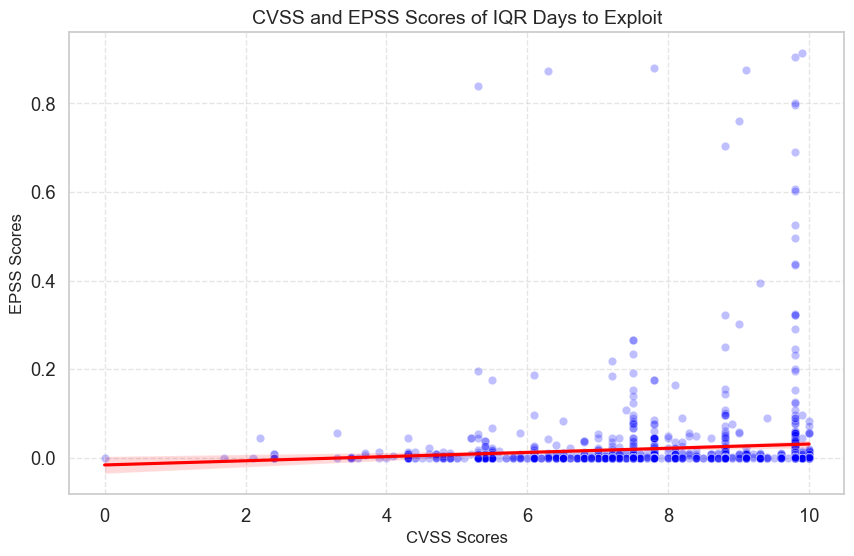

Plot saved: ../plots\the_cvss_scores_and_days_to_first_exploit_code_publication_of_iqr_days_to_exploit.png


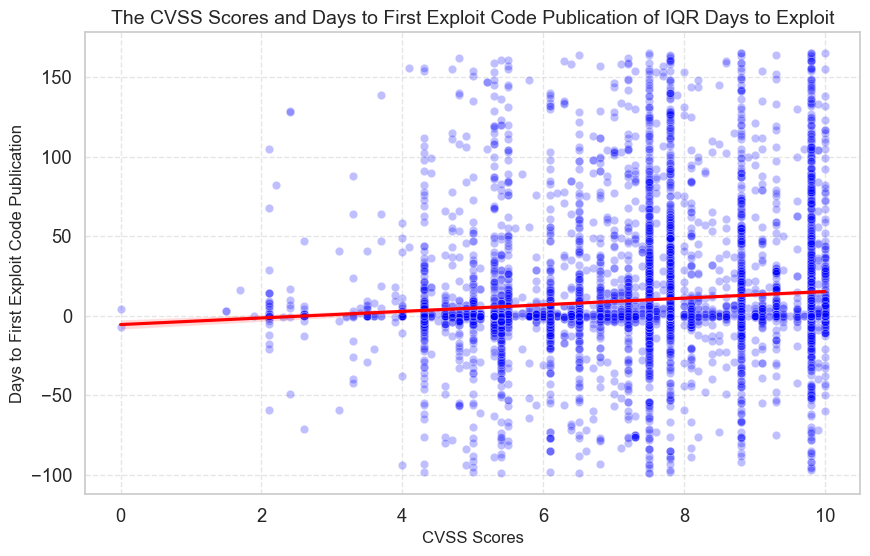

Plot saved: ../plots\epss_scores_and_days_to_first_exploit_code_publication_of_iqr_days_to_exploit.png


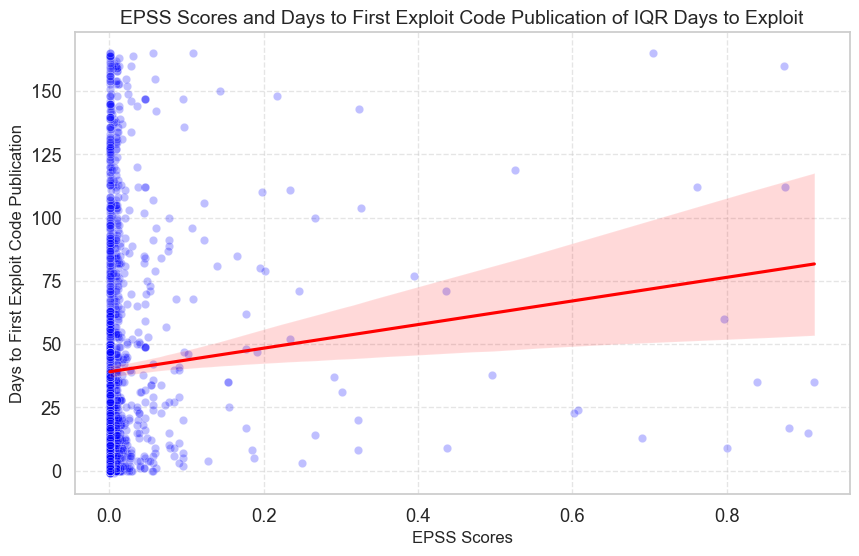

Plot saved: ../plots\epss_scores_and_exploit_count_of_iqr_days_to_exploit.png


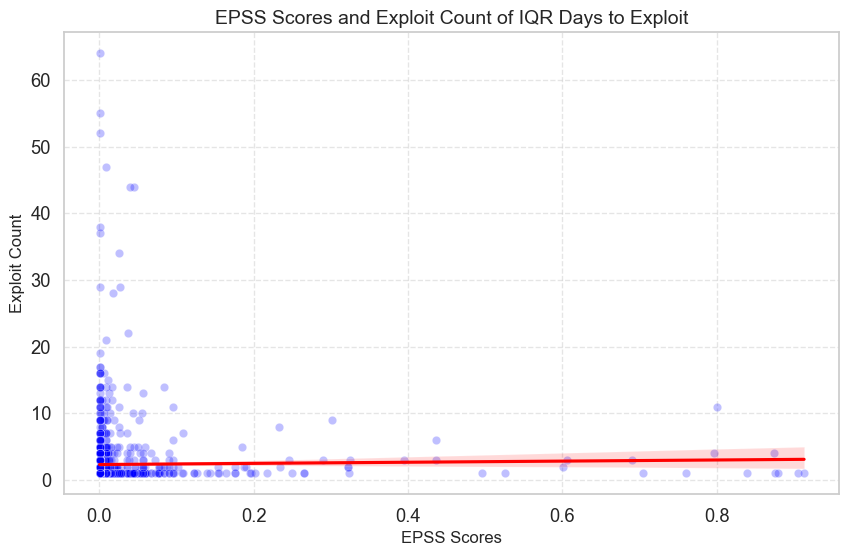

Plot saved: ../plots\cvss_scores_and_exploit_count_of_iqr_days_to_exploit.png


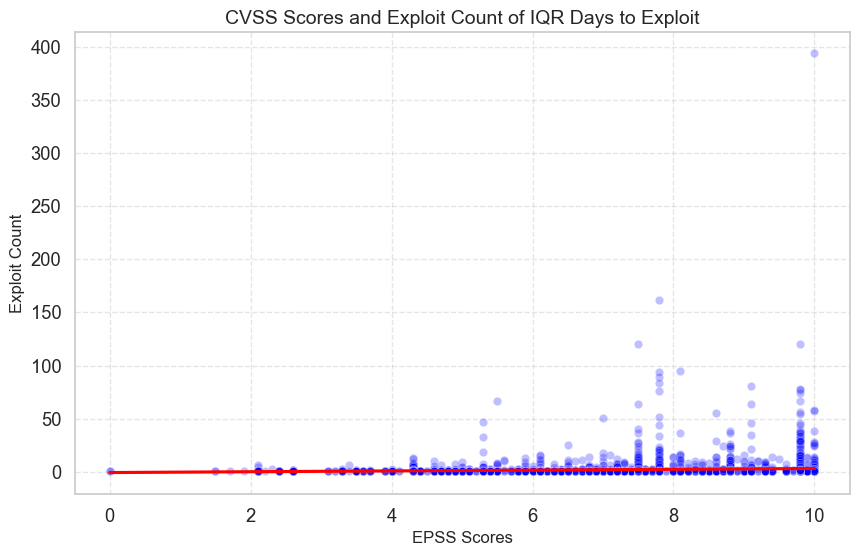

In [16]:
plotter.plot_scatter(
    iqr_df,
    iqr_df['cvss'],
    iqr_df['epss_0'],
    title='CVSS and EPSS Scores of IQR Days to Exploit',
    xlabel='CVSS Scores',
    ylabel='EPSS Scores',
    color='blue',
    alpha=0.25
)
plotter.plot_scatter(
    iqr_df,
    iqr_df['cvss'],
    iqr_df['days_to_poc_exploit'],
    title='The CVSS Scores and Days to First Exploit Code Publication of IQR Days to Exploit',
    xlabel='CVSS Scores',
    ylabel='Days to First Exploit Code Publication',
    color='blue',
    alpha=0.25
)
plotter.plot_scatter(
    iqr_df,
    iqr_df['epss_0'],
    iqr_df['days_to_poc_exploit'],
    title='EPSS Scores and Days to First Exploit Code Publication of IQR Days to Exploit',
    xlabel='EPSS Scores',
    ylabel='Days to First Exploit Code Publication',
    color='blue',
    alpha=0.25
)
plotter.plot_scatter(
    iqr_df,
    iqr_df['epss_0'],
    iqr_df['exploit_count'],
    title='EPSS Scores and Exploit Count of IQR Days to Exploit',
    xlabel='EPSS Scores',
    ylabel='Exploit Count',
    color='blue',
    alpha=0.25
)
plotter.plot_scatter(
    iqr_df,
    iqr_df['cvss'],
    iqr_df['exploit_count'],
    title='CVSS Scores and Exploit Count of IQR Days to Exploit',
    xlabel='EPSS Scores',
    ylabel='Exploit Count',
    color='blue',
    alpha=0.25
)